<a href="https://colab.research.google.com/github/aet-lang/Contract-Awards-in-Investment-Project-Financing/blob/main/Contract_Awards_in_Investment_Project_Financing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import all necessary libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate

## Load the dataset

In [5]:
!pip install -q gdown

import gdown

file_id = "1N6_PBk1T2PvhaATWsSHb9-vJYEnPcOlM"
url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(url, "contract_data.csv", quiet=False)

df = pd.read_csv("contract_data.csv")
df.head()

Downloading...
From (original): https://drive.google.com/uc?id=1N6_PBk1T2PvhaATWsSHb9-vJYEnPcOlM
From (redirected): https://drive.google.com/uc?id=1N6_PBk1T2PvhaATWsSHb9-vJYEnPcOlM&confirm=t&uuid=0d985403-5982-41a4-ae96-ca0227a4c5aa
To: /content/contract_data.csv
100%|██████████| 112M/112M [00:00<00:00, 248MB/s]


,As of Date,Fiscal Year,Region,Borrower Country / Economy,Borrower Country / Economy Code,Project ID,Project Name,Project Global Practice,Procurement Category,Procurement Method,WB Contract Number,Contract Description,Borrower Contract Reference Number,Contract Signing Date,Supplier ID,Supplier,Supplier Country / Economy,Supplier Country / Economy Code,Supplier Contract Amount (USD),Review type
0,06/19/2025,2017,South Asia,Afghanistan,AF,P120397,Afghanistan Agricultural Inputs Project (AAIP),Agriculture;Industry & Trade/Ser,Consultant Services,Individual Consultant Selection,1318576,Legal Specialst for Quarantine,MAIL/WB/IAIDS/IC/012,11/01/2016,192025.0,MR. LUTFULLAH SADAT,Afghanistan,AF,27006.76,NaN
1,06/19/2025,2017,Middle East and North Africa,Lebanon,LB,P133226,Lebanon Fiscal Management Reform 2,NaN,Consultant Services,Individual Consultant Selection,1517913,Signed Contract relative to the PMU Positions ...,2,11/30/2016,173999.0,MARWAN TAMIM (MR.),Lebanon,LB,151200.00,NaN
2,06/19/2025,2017,Middle East and North Africa,Lebanon,LB,P133226,Lebanon Fiscal Management Reform 2,NaN,Consultant Services,Individual Consultant Selection,1517959,Title on Consulting services as International ...,4,11/02/2016,166247.0,MOUNIR RACHED,Lebanon,LB,312000.00,NaN
3,06/19/2025,2017,Middle East and North Africa,Lebanon,LB,P149242,Emergency National Poverty Targeting Program P...,Social Protection,Consultant Services,Direct Selection,1524264,Procurement Assistant - FOT,C-IC036,09/07/2016,178397.0,JESSY EL KHOURY,Lebanon,LB,76800.00,Prior
4,06/19/2025,2017,Middle East and North Africa,Lebanon,LB,P149242,Emergency National Poverty Targeting Program P...,Social Protection,Consultant Services,Direct Selection,1524268,Procurement Specialist - FOT,C-IC035,09/07/2016,133992.0,NATHALIE GEBRAYEL,Lebanon,LB,195200.00,Prior


## Dataset information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294626 entries, 0 to 294625
Data columns (total 20 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   As of Date                          294626 non-null  object 
 1   Fiscal Year                         294626 non-null  int64  
 2   Region                              294626 non-null  object 
 3   Borrower Country / Economy          294626 non-null  object 
 4   Borrower Country / Economy Code     289111 non-null  object 
 5   Project ID                          294626 non-null  object 
 6   Project Name                        294626 non-null  object 
 7   Project Global Practice             272737 non-null  object 
 8   Procurement Category                294626 non-null  object 
 9   Procurement Method                  294626 non-null  object 
 10  WB Contract Number                  294626 non-null  int64  
 11  Contract Description      

## Drop duplicates

In [7]:
df.drop_duplicates(inplace=True)

## Fill all missing values

In [8]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

## Visualize missing data

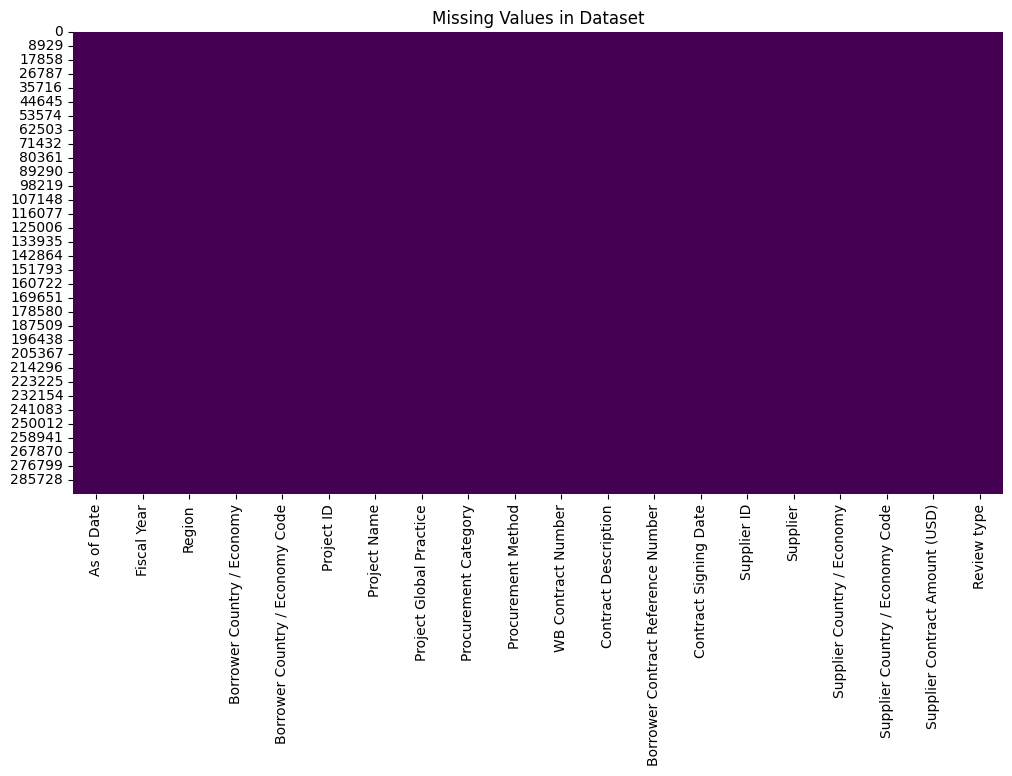

In [9]:
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Dataset")
plt.show()

### Convert date columns

In [10]:
df["As of Date"] = pd.to_datetime(df["As of Date"])
df["Contract Signing Date"] = pd.to_datetime(df["Contract Signing Date"])

### Visualize target variable distribution

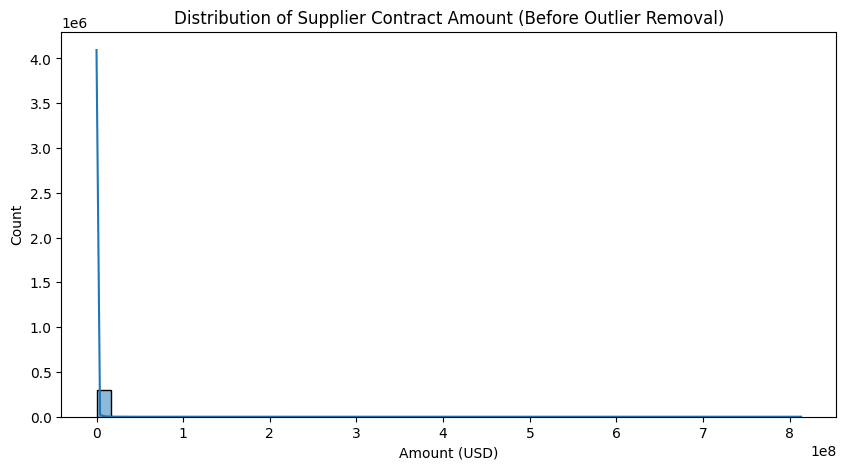

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(df["Supplier Contract Amount (USD)"], bins=50, kde=True)
plt.title("Distribution of Supplier Contract Amount (Before Outlier Removal)")
plt.xlabel("Amount (USD)")
plt.show()

## Boxplot of target

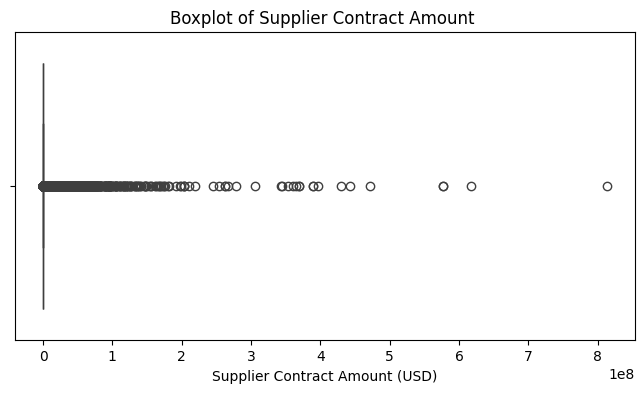

In [12]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["Supplier Contract Amount (USD)"])
plt.title("Boxplot of Supplier Contract Amount ")
plt.show()

### Encode Categorical Columns


In [13]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

### Target Separation


In [14]:
target_col = "Supplier Contract Amount (USD)"
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found. Available columns: {df.columns.tolist()}")

### Distribution of Target

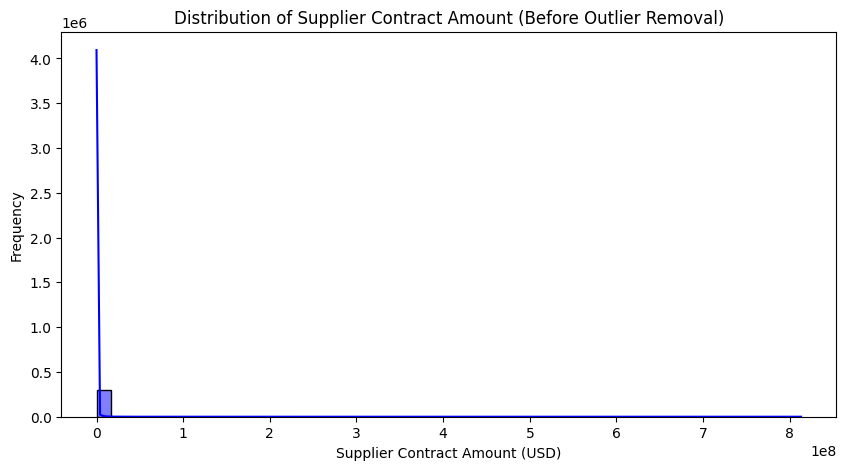

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(df[target_col], bins=50, kde=True, color='blue')
plt.title("Distribution of Supplier Contract Amount (Before Outlier Removal)")
plt.xlabel("Supplier Contract Amount (USD)")
plt.ylabel("Frequency")
plt.show()

### Outlier removal

In [16]:
Q1 = df[target_col].quantile(0.25)
Q3 = df[target_col].quantile(0.75)
IQR = Q3 - Q1

### Filter

In [17]:
filtered_df = df[(df[target_col] >= Q1 - 1.5 * IQR) &
                 (df[target_col] <= Q3 + 1.5 * IQR)].copy()

### Label Encode

In [18]:
for col in filtered_df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    filtered_df[col] = le.fit_transform(filtered_df[col].astype(str))


### Prepare Features and Labels

In [19]:
X = filtered_df.drop(columns=[target_col, "As of Date", "Contract Signing Date"])
y = filtered_df[target_col]

### Feature Scaling

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Train-Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

### Define smaller subsets for faster testing

In [22]:
X_train_small = X_train[:2000]
y_train_small = y_train[:2000]
X_test_small = X_test[:500]
y_test_small = y_test[:500]

### Evaluation function

In [23]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"\\n📊 {name} Results:")
    print(f"  - MAE: {mae:.2f}")
    print(f"  - MSE: {mse:.2f}")
    print(f"  - R² Score: {r2:.4f}")

    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{name} - Actual vs Predicted")
    plt.grid(True)
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(7, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{name} - Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    return {'name': name, 'mae': mae, 'mse': mse, 'r2': r2, 'y_pred': y_pred}


### Evaluate Linear Regression and Random Forest

\n📊 Linear Regression Results:
  - MAE: 44660.87
  - MSE: 3733131417.64
  - R² Score: 0.0763


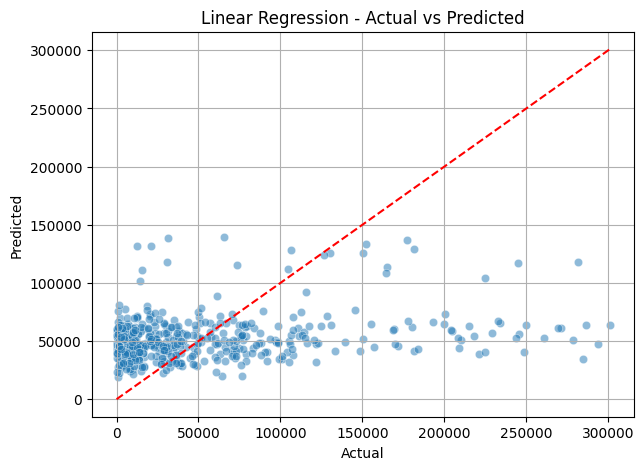

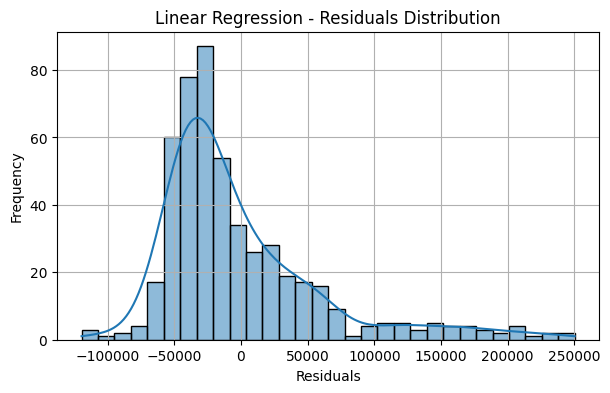

\n📊 Random Forest Results:
  - MAE: 38965.56
  - MSE: 3192363739.12
  - R² Score: 0.2101


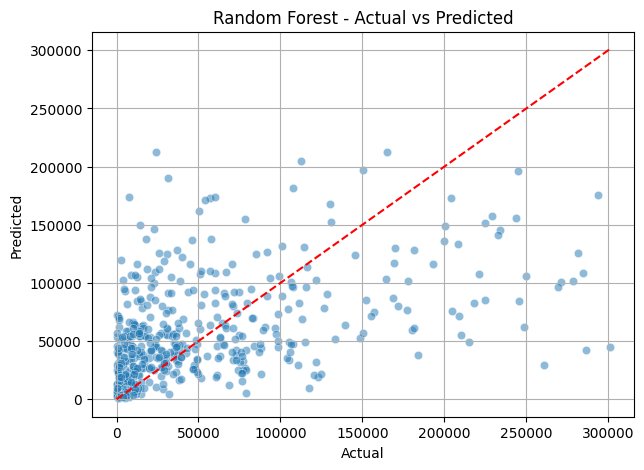

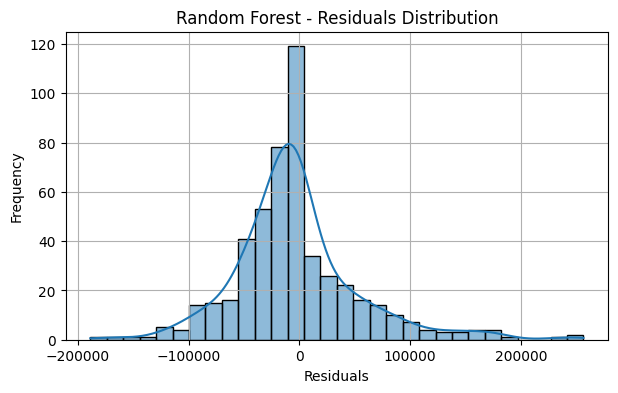

In [24]:
r_result = evaluate_model("Linear Regression", LinearRegression(), X_train_small, y_train_small, X_test_small, y_test_small)
rf_result = evaluate_model("Random Forest", RandomForestRegressor(n_estimators=20, random_state=42), X_train_small, y_train_small, X_test_small, y_test_small)


### Cross-validation scores

In [25]:
def cross_validate_model(model, name):
    scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=10)
    print(f"{name} Cross-Validation R² Scores:\\n", scores)
    print(f"Mean R²: {scores.mean():.4f}, Std: {scores.std():.4f}\\n")

cross_validate_model(LinearRegression(), "Linear Regression")
cross_validate_model(RandomForestRegressor(n_estimators=20, random_state=42), "Random Forest")

Linear Regression Cross-Validation R² Scores:\n [0.05721646 0.06654654 0.0514831  0.02667854 0.07152377 0.07598154
 0.06654251 0.04007773 0.07176293 0.03633788]
Mean R²: 0.0564, Std: 0.0162\n
Random Forest Cross-Validation R² Scores:\n [0.23964187 0.36589431 0.37473825 0.41626443 0.42305022 0.4247594
 0.40946539 0.39910436 0.41315597 0.19401698]
Mean R²: 0.3660, Std: 0.0775\n


### Learning Curves

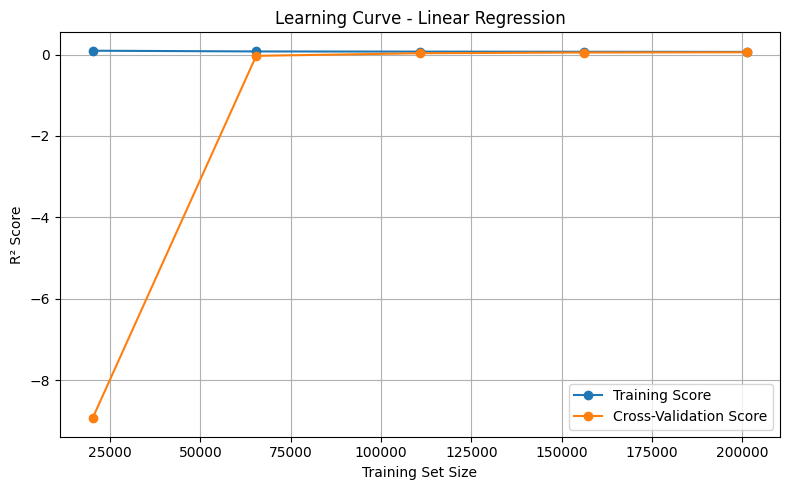

In [26]:
def plot_learning_curve(estimator, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X_scaled, y,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label='Training Score', marker='o')
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score', marker='o')
    plt.title(f"Learning Curve - {title}")
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_learning_curve(LinearRegression(), "Linear Regression")

### GridSearchCV on Random Forest

In [27]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train, y_train)

print(" Best RF Parameters:", grid.best_params_)
print("Best R² Score:", grid.best_score_)

🔍 Best RF Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Best R² Score: 0.5506987208338231


### Feature Importance

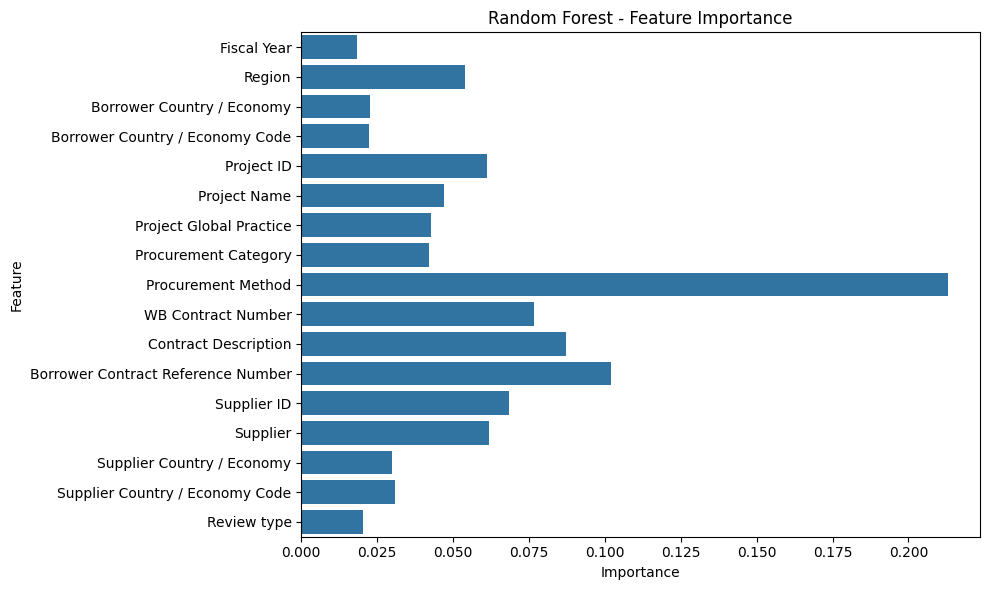

In [28]:
best_rf = grid.best_estimator_
feat_imp = best_rf.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp, y=features)
plt.title("Random Forest - Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Residuals vs Fitted for best RF

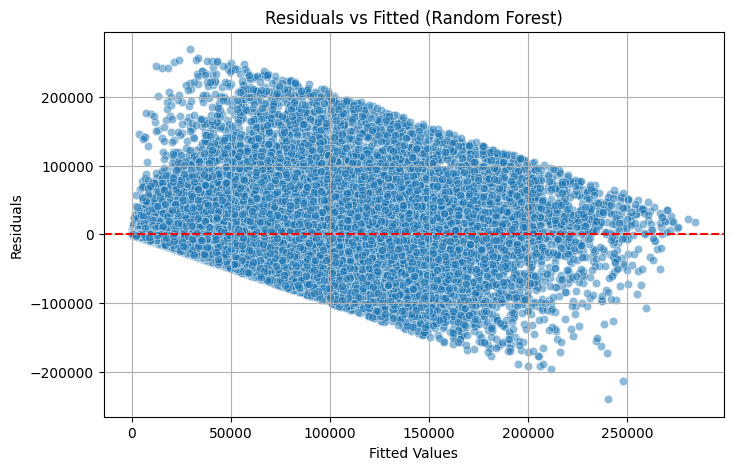

In [29]:
y_pred_rf = best_rf.predict(X_test)
residuals = y_test - y_pred_rf

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_rf, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Random Forest)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

### Define smaller subsets for faster testing

### Final Summary Table

In [34]:
y_pred_rf = rf_result['y_pred']

results = [
    ["Linear Regression", r_result['mae'], r_result['mse'], r_result['r2']],
    ["Random Forest", rf_result['mae'], rf_result['mse'], rf_result['r2']],
    ["Tuned Random Forest",
     mean_absolute_error(y_test_small, y_pred_rf),
     mean_squared_error(y_test_small, y_pred_rf),
     r2_score(y_test_small, y_pred_rf)]
]

headers = ["Model", "MAE", "MSE", "R²"]

print("\n Final Model Comparison:")
print(tabulate(results, headers=headers, floatfmt=".2f"))



 Final Model Comparison:
Model                     MAE            MSE    R²
-------------------  --------  -------------  ----
Linear Regression    44660.87  3733131417.64  0.08
Random Forest        38965.56  3192363739.12  0.21
Tuned Random Forest  38965.56  3192363739.12  0.21
